In [1]:
import numpy as np
import os
import math
from PIL import Image
import pandas as pd

# Clustering
from sklearn.cluster import AgglomerativeClustering # 1) Agglomerative-Hierarchical
from sklearn.cluster import KMeans                  # 2) K-Means
from sklearn.mixture import GaussianMixture         # 3) Gaussian Mixture Models
from sklearn.metrics import make_scorer
from skimage.color import rgb2hed
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

# Evaluation
from sklearn import metrics
from skimage.external import tifffile
from skimage.measure import compare_mse
# from skimage.metrics import structural_similarity as ssim

from sklearn.decomposition import PCA, KernelPCA               # 2) PCA
from sklearn.manifold import TSNE

# Load Autoencoder                                  # 3) Autoencoder (Deep dimensionality reduction)
from keras.models import load_model
from keras.models import Model

import cv2

import matplotlib.pyplot as plt 
%matplotlib inline

import newscripts as myutils

Using TensorFlow backend.


In [2]:
# Load training data

train_directory = "../../Data/Kather_all_train"

X_train = []
train_image_names = []

for filename in os.listdir(train_directory):
    if filename.endswith('tif'):
        image = cv2.imread(os.path.join(train_directory, filename), cv2.IMREAD_UNCHANGED)
        resized_image = cv2.resize(image, (96, 96)) 
        X_train.append(np.asarray( resized_image, dtype="uint8" ))
        train_image_names.append(filename)

y_train = myutils.loadLabelsFromsubdirectoryindex(train_image_names, "../../Data/Kather_original_train")

# Load testing data

test_directory = "../../Data/Kather_all_test"

X_test = []
test_image_names = []

for filename in os.listdir(test_directory):
    if filename.endswith('tif'):
        image = cv2.imread(os.path.join(test_directory, filename), cv2.IMREAD_UNCHANGED)
        resized_image = cv2.resize(image, (96, 96)) 
        X_test.append(np.asarray( resized_image, dtype="uint8" ))
        test_image_names.append(filename)

y_test = myutils.loadLabelsFromsubdirectoryindex(test_image_names, "../../Data/Kather_original_test")

In [3]:
autoencoder = load_model('../Autoencoders/SavedModels/autoencoder_train_epochs100_batch32_best.h5') # 6 x 6 x 16
# autoencoder.summary()

W0419 18:00:49.423432 4321239936 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0419 18:00:52.779139 4321239936 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



In [4]:
layer_name = 'conv2d_30' # 6 x 6 x 32
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)


In [5]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

# Normalise
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.


In [6]:
X_train_enc = encoder.predict(X_train)
print(X_train_enc.shape)

(4200, 6, 6, 32)


In [7]:
X_test_enc = encoder.predict(X_test)
print(X_test.shape)

(800, 96, 96, 3)


In [8]:
X_train_enc = X_train_enc.reshape(X_train_enc.shape[0] , -1) # Reshape for scaling
X_train_enc = StandardScaler().fit_transform(X_train_enc) # Scale

X_test_enc = X_test_enc.reshape(X_test_enc.shape[0] , -1) # Reshape for scaling
X_test_enc = StandardScaler().fit_transform(X_test_enc) # Scale

In [9]:
# Evaluate on testing data using grid search  cv
parameters = {'covariance_type':('full', 'spherical', 'diag', 'tied'), 'n_components':[8],'random_state':[0,19,42]}
clf = GridSearchCV(GaussianMixture(), parameters, scoring=make_scorer(metrics.completeness_score))

clf.fit(X_train_enc, y_train)
print(clf.best_estimator_)
print(clf.best_score_)

parameters = {'init':('k-means++', 'random'), 'n_clusters':[8],'random_state':[0,19,42]}
clf2 = GridSearchCV(KMeans(), parameters, scoring=make_scorer(metrics.completeness_score))

clf2.fit(X_train_enc, y_train)
print(clf2.best_estimator_)
clf2.best_score_

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)
0.6122045632654893


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=8,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=19,
       tol=0.0001, verbose=0)


0.5654894544765823

In [10]:
# best estimator

gmm_best = GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None).fit(X_train_enc)

gmm_labels = gmm_best.predict(X_test_enc)
print(metrics.completeness_score(y_test,gmm_labels))


0.6486378847810731


In [11]:
print(metrics.completeness_score(y_train,gmm_best.predict(X_train_enc)))

0.6271775433831082


In [12]:
# best estimator

k_best = KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=8,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=19,
       tol=0.0001, verbose=0).fit(X_train_enc)

k_labels = k_best.predict(X_test_enc)
print(metrics.completeness_score(y_test,k_labels))


0.6079802664085354


In [13]:
import shutil

def symlink_rel(src, dst):
    rel_path_src = os.path.relpath(src, os.path.dirname(dst))
    os.symlink(rel_path_src, dst)
    
def clusterintoDirectories(labels, path, imagenamesList):
    # remove existing subdirectories first to avoid overlap
    sub_directories = [str(i) for i in range(8)]

    for cluster in sub_directories:
        if (cluster in os.listdir(path)) and (os.path.isdir(os.path.join(path , cluster))):
            shutil.rmtree(os.path.join(path , cluster))

    for filename in os.listdir(path):
        if filename.endswith('.tif'):
            for cluster in sub_directories: # count of distinct elements = no. of clusters
                os.makedirs(path + '/{}'.format(cluster) , exist_ok=True)
    
#     print(len(imagenamesList))
#     print(sub_directories)
#     print(len(labels))
    
    for i in range(len(imagenamesList)):
#         print(i)
        # if there isnt already a symlink of this image in the coressponding subdirectory
#         print(labels[i])
        if imagenamesList[i] not in os.listdir(path + '/' + sub_directories[labels[i]]): 
            symlink_rel(path + '/{}'.format(imagenamesList[i]) , 
                       path + '/{}'.format(labels[i]) + '/' + imagenamesList[i])

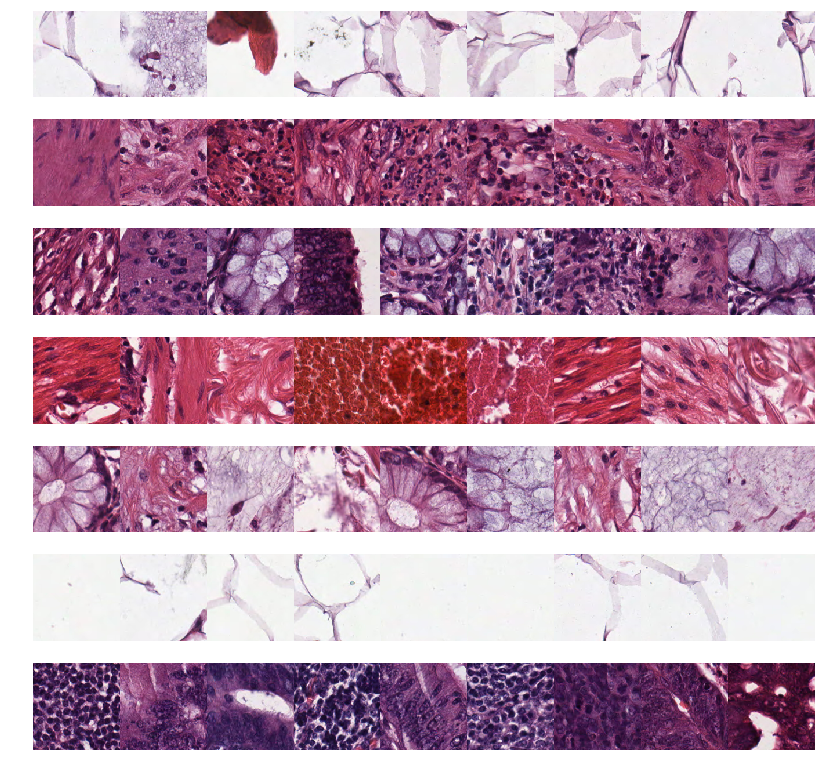

In [14]:
clusterintoDirectories(k_labels, test_directory, test_image_names)
myutils.pltPathologyClusters(k_labels, test_directory)

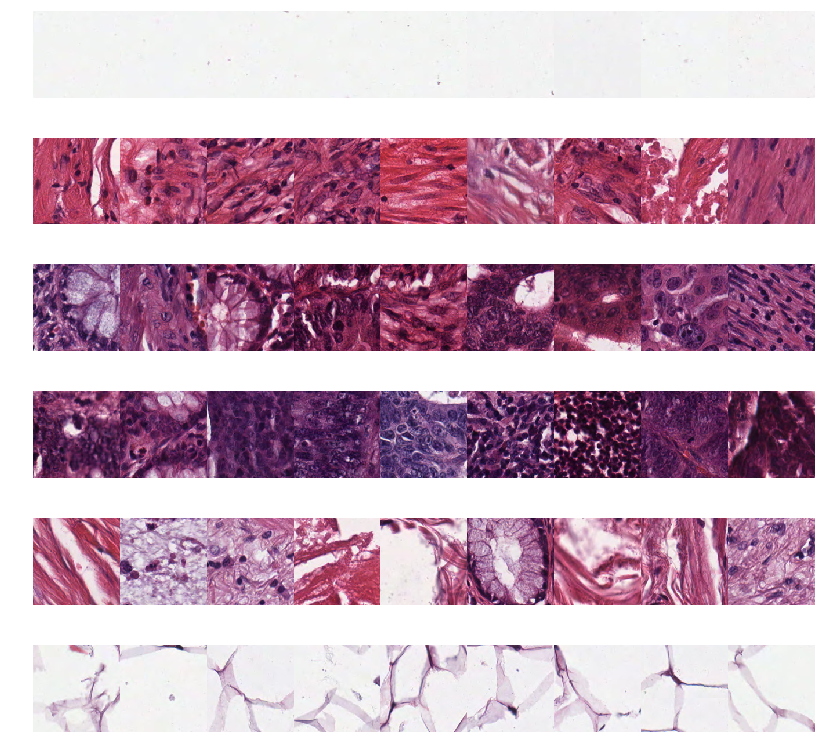

In [15]:
clusterintoDirectories(gmm_labels, test_directory, test_image_names)
myutils.pltPathologyClusters(gmm_labels, test_directory)

In [9]:
# PCA 
# Reduce Dimensions
# PCA 
pca1 = PCA(n_components=500)
transformed_train = pca1.fit_transform(X_train_enc)

pca2 = PCA(n_components=500)
transformed_test = pca2.fit_transform(X_test_enc)

print(sum(pca1.explained_variance_ratio_))
print(sum(pca2.explained_variance_ratio_))
# print(pca1.n_components_)
# pca2.n_components_

0.9561573800747283
0.9924094776652055


In [17]:
# Evaluate on testing data using grid search  cv
parameters = {'covariance_type':('full', 'spherical', 'diag', 'tied'), 
              'n_components':[8],'random_state':[0,19,42], "reg_covar" : [1e-5] }
clf = GridSearchCV(GaussianMixture(), parameters, scoring=make_scorer(metrics.completeness_score))

clf.fit(transformed_train, y_train)
print(clf.best_estimator_)
print(clf.best_score_)

parameters = {'init':('k-means++', 'random'), 'n_clusters':[8],'random_state':[0,19,42]}
clf2 = GridSearchCV(KMeans(), parameters, scoring=make_scorer(metrics.completeness_score))

clf2.fit(transformed_train, y_train)
print(clf2.best_estimator_)
clf2.best_score_

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=19, reg_covar=1e-05, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)
0.8519518981380388


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=8,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=19,
       tol=0.0001, verbose=0)


0.5615962477204063

In [18]:
# best estimator

gmm_best = GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-05, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None).fit(X_train_enc)

gmm_labels = gmm_best.predict(X_test_enc)
print(metrics.completeness_score(y_test,gmm_labels))


1.0


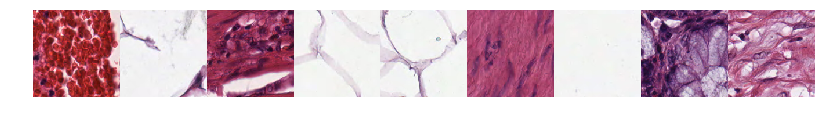

In [19]:
clusterintoDirectories(gmm_labels, test_directory, test_image_names)
myutils.pltPathologyClusters(gmm_labels, test_directory)

In [20]:
# best estimator

k_best = KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=8,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=19,
       tol=0.0001, verbose=0).fit(X_train_enc)

k_labels = k_best.predict(X_test_enc)
print(metrics.completeness_score(y_test,k_labels))


0.6079802664085354


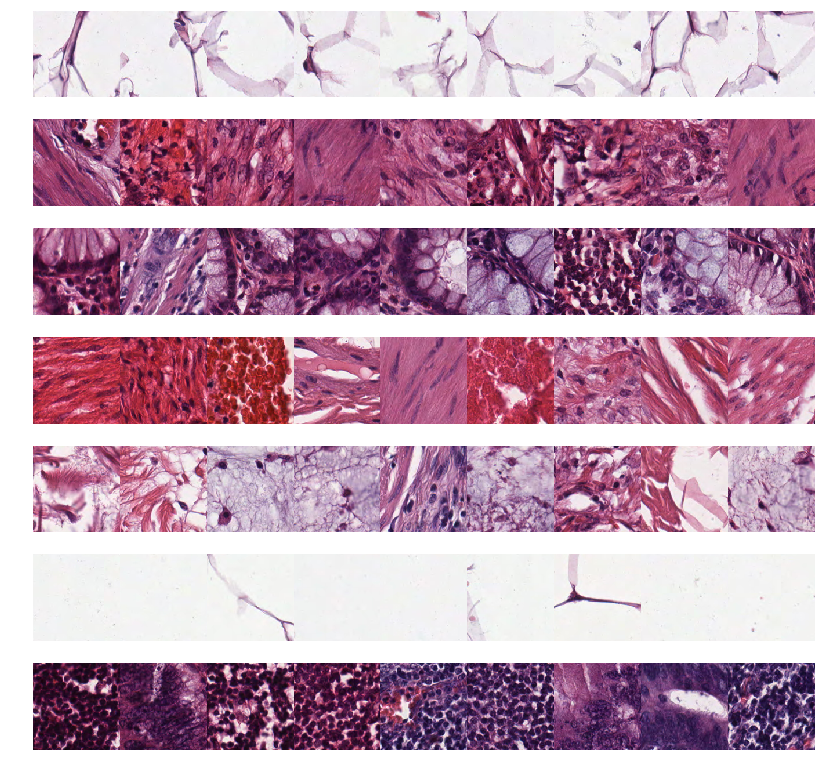

In [22]:
clusterintoDirectories(k_labels, test_directory, test_image_names)
myutils.pltPathologyClusters(k_labels, test_directory)

In [23]:
pca3 = PCA(n_components=250)
transformed_test_tsne = pca3.fit_transform(X_test_enc)

print(sum(pca3.explained_variance_ratio_))
# pca2.n_components_

0.9352531469776295


In [27]:
def plotdiffTsne(X):
    fig, axs = plt.subplots(2, 2, figsize=(13, 7))

#     tsne1 = TSNE(n_components=2, perplexity = 15).fit_transform(X)
#     kmeans1 = KMeans(n_clusters=8).fit(tsne1)

#     axs[0, 0].scatter(tsne1[:, 0], tsne1[:, 1], c=kmeans1.labels_, cmap='viridis')
#     axs[0, 0].set_title('TSNE perplexity = 15')

    tsne2 = TSNE(n_components=2, perplexity = 30).fit_transform(X)
    kmeans2 = KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=8,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=19,
       tol=0.0001, verbose=0).fit(tsne2)

    axs[0, 1].scatter(tsne2[:, 0], tsne2[:, 1], c=kmeans2.labels_, cmap='viridis')
    axs[0, 1].set_title('TSNE perplexity = 30')

#     tsne3 = TSNE(n_components=2, perplexity = 50).fit_transform(X)
#     kmeans3 = KMeans(n_clusters=8).fit(tsne3)

#     axs[1, 0].scatter(tsne3[:, 0], tsne3[:, 1], c=kmeans3.labels_, cmap='viridis')
#     axs[1, 0].set_title('TSNE perplexity = 50')

    tsne4 = TSNE(n_components=2, perplexity = 90).fit_transform(X)
    kmeans4 = KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=8,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=19,
       tol=0.0001, verbose=0).fit(tsne4)

    axs[1, 1].scatter(tsne4[:, 0], tsne4[:, 1], c=kmeans4.labels_, cmap='viridis')
    axs[1, 1].set_title('TSNE perplexity = 90')
    
    plt.savefig('TSNE-CAE.png')
    plt.show()

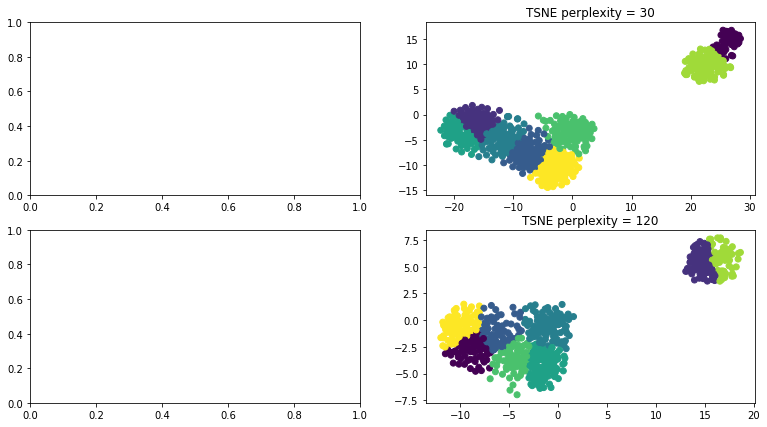

In [28]:
plotdiffTsne(transformed_test_tsne)

In [13]:
print(transformed_train.shape)
transformed_test.shape

(4200, 500)


(800, 500)

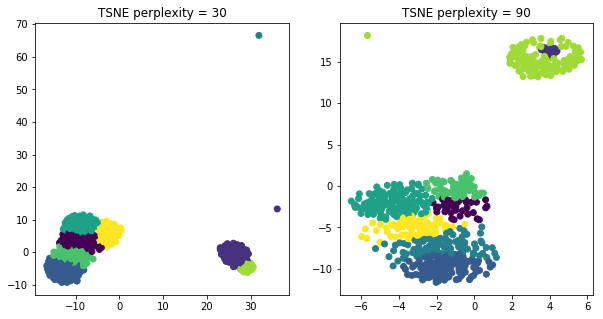

In [16]:
est = GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-04, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

tsne2 = TSNE(n_components=2, perplexity = 30).fit_transform(transformed_test)
gmm1 = est.fit(tsne2)
gmm1_labels = gmm1.predict(tsne2)

axs[0].scatter(tsne2[:, 0], tsne2[:, 1], c=gmm1_labels, cmap='viridis')
axs[0].set_title('TSNE perplexity = 30')


tsne4 = TSNE(n_components=2, perplexity = 90).fit_transform(transformed_test)
gmm2 = est.fit(tsne4)
labels2 = gmm2.predict(tsne4)

axs[1].scatter(tsne4[:, 0], tsne4[:, 1], c=labels2, cmap='viridis')
axs[1].set_title('TSNE perplexity = 90')

plt.savefig('TSNE-final-CAES-2.png')
plt.show()

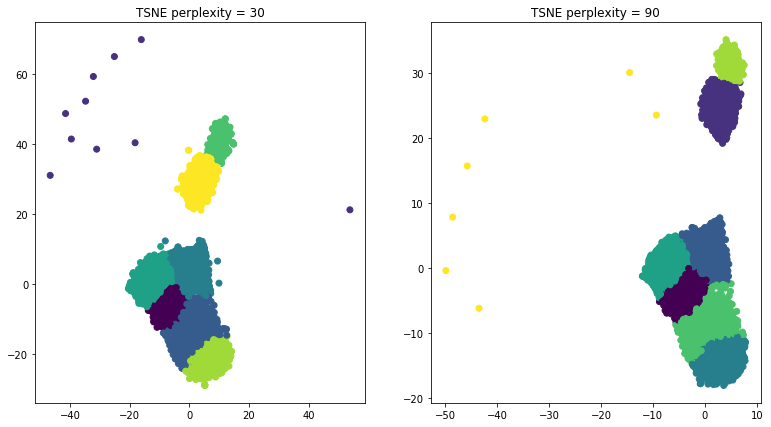

In [12]:
est = GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-05, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

fig, axs = plt.subplots(1, 2, figsize=(13, 7))

tsne2 = TSNE(n_components=2, perplexity = 30).fit_transform(transformed_train)
gmm1 = est.fit(tsne2)
gmm1_labels = gmm1.predict(tsne2)

axs[0].scatter(tsne2[:, 0], tsne2[:, 1], c=gmm1_labels, cmap='viridis')
axs[0].set_title('TSNE perplexity = 30')


tsne4 = TSNE(n_components=2, perplexity = 90).fit_transform(transformed_train)
gmm2 = est.fit(tsne4)
labels2 = gmm2.predict(tsne4)

axs[1].scatter(tsne4[:, 0], tsne4[:, 1], c=labels2, cmap='viridis')
axs[1].set_title('TSNE perplexity = 90')

plt.savefig('TSNE-final-CAES-2.png')
plt.show()